# AutoML Regression


<img src='https://github.com/retkowsky/images/blob/master/AzureMLservicebanniere.png?raw=true'>

In [1]:
import sys
print("Version Python : ", sys.version)

Version Python :  3.6.9 |Anaconda, Inc.| (default, Jul 30 2019, 19:07:31) 
[GCC 7.3.0]


In [2]:
import datetime
now = datetime.datetime.now()
print(now)

2020-04-17 14:30:41.097032


In [3]:
import azureml.core
print("Version Azure ML service :", azureml.core.VERSION)

Version Azure ML service : 1.2.0


In [4]:
import logging

from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import azureml.core
from azureml.core.experiment import Experiment
from azureml.core.workspace import Workspace
import azureml.dataprep as dprep
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset

## 1. Création expérimentation

In [44]:
ws = Workspace.from_config()

experiment_name = 'Exemple3-automlregression'
project_folder = './sample_projects/workshop3'

experiment = Experiment(ws, experiment_name)

output = {}
output['Azure ML version'] = azureml.core.VERSION
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Project Directory'] = project_folder
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
pd.DataFrame(data = output, index = ['']).T

,
Azure ML version,1.2.0
Workspace Name,workshopAML2020
Resource Group,workshopAML2020-rg
Location,westeurope
Project Directory,./sample_projects/workshop3
Experiment Name,Exemple3-automlregression


In [45]:
from azureml.core import ComputeTarget, Datastore, Dataset

print("Compute Targets :")
for compute_name in ws.compute_targets:
    compute = ws.compute_targets[compute_name]
    print("\t", compute.name, ':', compute.type)
    
print("Datastores :")
for datastore_name in ws.datastores:
    datastore = Datastore.get(ws, datastore_name)
    print("\t", datastore.name, ':', datastore.datastore_type)
    
print("Datasets :")
for dataset_name in list(ws.datasets.keys()):
    dataset = Dataset.get_by_name(ws, dataset_name)
    print("\t", dataset.name)

Compute Targets :
	 instance : ComputeInstance
Datastores :
	 teststorageserge : AzureBlob
	 azureml_globaldatasets : AzureBlob
	 workspaceblobstore : AzureBlob
	 workspacefilestore : AzureFile
Datasets :
	 dataset
	 mynewdataset
	 monfichier
	 Iris
	 mnist dataset
	 diabetes dataset


## 2. Chargement des données

In [6]:
from sklearn.datasets import load_boston
boston=load_boston()
df = pd.DataFrame(boston.data, columns=boston.feature_names)

df['target'] = boston.target

In [7]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [8]:
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.01,18.00,2.31,0.00,0.54,6.58,65.20,4.09,1.00,296.00,15.30,396.90,4.98,24.00
1,0.03,0.00,7.07,0.00,0.47,6.42,78.90,4.97,2.00,242.00,17.80,396.90,9.14,21.60
2,0.03,0.00,7.07,0.00,0.47,7.18,61.10,4.97,2.00,242.00,17.80,392.83,4.03,34.70
3,0.03,0.00,2.18,0.00,0.46,7.00,45.80,6.06,3.00,222.00,18.70,394.63,2.94,33.40
4,0.07,0.00,2.18,0.00,0.46,7.15,54.20,6.06,3.00,222.00,18.70,396.90,5.33,36.20


In [9]:
df.corr()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
CRIM,1.00,-0.20,0.41,-0.06,0.42,-0.22,0.35,-0.38,0.63,0.58,0.29,-0.39,0.46,-0.39
ZN,-0.20,1.00,-0.53,-0.04,-0.52,0.31,-0.57,0.66,-0.31,-0.31,-0.39,0.18,-0.41,0.36
INDUS,0.41,-0.53,1.00,0.06,0.76,-0.39,0.64,-0.71,0.60,0.72,0.38,-0.36,0.60,-0.48
CHAS,-0.06,-0.04,0.06,1.00,0.09,0.09,0.09,-0.10,-0.01,-0.04,-0.12,0.05,-0.05,0.18
NOX,0.42,-0.52,0.76,0.09,1.00,-0.30,0.73,-0.77,0.61,0.67,0.19,-0.38,0.59,-0.43
RM,-0.22,0.31,-0.39,0.09,-0.30,1.00,-0.24,0.21,-0.21,-0.29,-0.36,0.13,-0.61,0.70
AGE,0.35,-0.57,0.64,0.09,0.73,-0.24,1.00,-0.75,0.46,0.51,0.26,-0.27,0.60,-0.38
DIS,-0.38,0.66,-0.71,-0.10,-0.77,0.21,-0.75,1.00,-0.49,-0.53,-0.23,0.29,-0.50,0.25
RAD,0.63,-0.31,0.60,-0.01,0.61,-0.21,0.46,-0.49,1.00,0.91,0.46,-0.44,0.49,-0.38
TAX,0.58,-0.31,0.72,-0.04,0.67,-0.29,0.51,-0.53,0.91,1.00,0.46,-0.44,0.54,-0.47


In [10]:
df.shape

(506, 14)

In [11]:
df.columns

Index(['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX',
       'PTRATIO', 'B', 'LSTAT', 'target'],
      dtype='object')

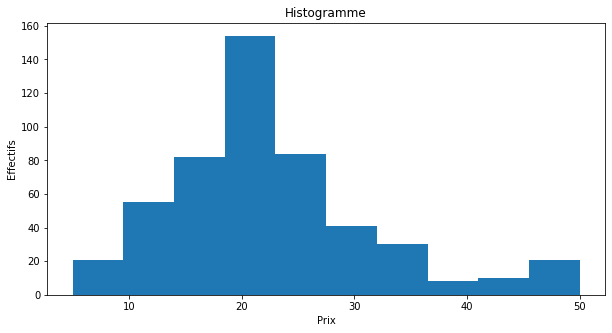

In [12]:
plt.figure(figsize=(10, 5))
plt.hist(df.target)
plt.title('Histogramme')
plt.xlabel('Prix')
plt.ylabel('Effectifs')
plt.show()

## 3. Configuration AutoML


> Documentation : https://docs.microsoft.com/en-us/azure/machine-learning/how-to-configure-auto-train

In [13]:
# Variable à modéliser
label ="target"

In [14]:
automl_settings = {
    "enable_early_stopping": True, 
    "iterations" : 15,
    "n_cross_validations": 3,
    "primary_metric": 'r2_score',
    "verbosity": logging.INFO
}

automl_config = AutoMLConfig(task = 'regression',
                             debug_log = 'automl3.log',
                             preprocess=True,
                             training_data = df,
                             label_column_name = label,
                             **automl_settings
                            )

WARNING - Parameter `preprocess` will be deprecated. Use `featurization`
WARNING - Detected both `preprocess` and `featurization`. `preprocess` is being deprecated and will be overridden by `featurization` setting.


## 4. AutoML

In [15]:
automl_run = experiment.submit(automl_config, show_output = True)

Running on local machine
Parent Run ID: AutoML_029dab7c-7bce-40a0-ba9a-dcdc1d9a7aa0

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing values imputation
STATUS:       PASSED
DESCRIPTION:  There were no missing values found in the training data.

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.

****************************************************************************

In [16]:
automl_run

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple3-automlregression,AutoML_029dab7c-7bce-40a0-ba9a-dcdc1d9a7aa0,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [17]:
# Widget
from azureml.widgets import RunDetails
RunDetails(automl_run).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## Autre AutoML avec whitelist et sans méthodes Ensemble

In [29]:
automl_settings2 = {
    "enable_early_stopping": True, 
    "iterations" : 5,
    "n_cross_validations": 3,
    "primary_metric": 'r2_score',
    "verbosity": logging.INFO
}

automl_config2 = AutoMLConfig(task = 'regression',
                             debug_log = 'automl31.log',
                             training_data = df,
                             whitelist_models=['LightGBM'],
                             enable_voting_ensemble=False,
                             enable_stack_ensemble=False,
                             label_column_name = label,
                             **automl_settings
                            )

In [30]:
automl_run2 = experiment.submit(automl_config2, show_output = True)

Running on local machine
Parent Run ID: AutoML_2c7fa392-59b9-4223-beaa-7fe0ef906723

Current status: DatasetEvaluation. Gathering dataset statistics.
Current status: FeaturesGeneration. Generating features for the dataset.
Current status: DatasetFeaturization. Beginning to fit featurizers and featurize the dataset.
Current status: DatasetFeaturizationCompleted. Completed fit featurizers and featurizing the dataset.
Current status: DatasetCrossValidationSplit. Generating individually featurized CV splits.

****************************************************************************************************
DATA GUARDRAILS: 

TYPE:         Missing values imputation
STATUS:       PASSED
DESCRIPTION:  There were no missing values found in the training data.

TYPE:         High cardinality feature detection
STATUS:       PASSED
DESCRIPTION:  Your inputs were analyzed, and no high cardinality features were detected.

****************************************************************************

In [33]:
automl_run2

Experiment,Id,Type,Status,Details Page,Docs Page
Exemple3-automlregression,AutoML_2c7fa392-59b9-4223-beaa-7fe0ef906723,automl,Completed,Link to Azure Machine Learning studio,Link to Documentation


In [34]:
# Widget
from azureml.widgets import RunDetails
RunDetails(automl_run2).show() 

_AutoMLWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': False, 'log_level': 'INFO', 's…

## 5. Référencement du meilleur modèle

In [38]:
best_run, fitted_model = automl_run2.get_output()
print(best_run)

Run(Experiment: Exemple3-automlregression,
Id: AutoML_2c7fa392-59b9-4223-beaa-7fe0ef906723_1,
Type: None,
Status: Completed)


In [39]:
print(fitted_model)

RegressionPipeline(pipeline=Pipeline(memory=None,
     steps=[('datatransformer', DataTransformer(enable_dnn=None, enable_feature_sweeping=None,
        feature_sweeping_config=None, feature_sweeping_timeout=None,
        featurization_config=None, force_text_dnn=None,
        is_cross_validation=None, is_onnx_compatible=None, logger=None,
        obser...0.15, silent=True, subsample=0.7,
         subsample_for_bin=200000, subsample_freq=1, verbose=-1))]),
          stddev=None)


In [41]:
# Liste des métriques
best_run_metrics = best_run.get_metrics()
for metric_name in best_run_metrics:
    metric = best_run_metrics[metric_name]
    print(metric_name, metric)

root_mean_squared_error 3.2514145656412903
residuals aml://artifactId/ExperimentRun/dcid.AutoML_2c7fa392-59b9-4223-beaa-7fe0ef906723_1/residuals
normalized_root_mean_squared_log_error 0.0671868596548975
mean_absolute_percentage_error 11.039624349581407
median_absolute_error 1.5146438637412214
spearman_correlation 0.9233753253281912
normalized_mean_absolute_error 0.0492270041983845
normalized_median_absolute_error 0.0336587525275827
mean_absolute_error 2.215215188927303
explained_variance 0.8745174495843063
r2_score 0.8736789106695474
root_mean_squared_log_error 0.14378432497901886
normalized_root_mean_squared_error 0.07225365701425089
predicted_true aml://artifactId/ExperimentRun/dcid.AutoML_2c7fa392-59b9-4223-beaa-7fe0ef906723_1/predicted_true


In [42]:
from azureml.core import Model

best_run.register_model(model_path='outputs/model.pkl', model_name='Exemple3-AutoML-Regression',
                        tags={'Training context':'Azure Auto ML'},
                        properties={'R2': best_run_metrics['r2_score'], 'RMSE': best_run_metrics['normalized_root_mean_squared_error']})

Model(workspace=Workspace.create(name='workshopAML2020', subscription_id='70b8f39e-8863-49f7-b6ba-34a80799550c', resource_group='workshopAML2020-rg'), name=Exemple3-AutoML-Regression, id=Exemple3-AutoML-Regression:7, version=7, tags={'Training context': 'Azure Auto ML'}, properties={'R2': '0.8736789106695474', 'RMSE': '0.07225365701425089'})

In [43]:
# Liste des modèles référencés
for model in Model.list(ws):
    print(model.name, 'Version =', model.version)
    for tag_name in model.tags:
        tag = model.tags[tag_name]
        print ('\t',tag_name, ':', tag)
    for prop_name in model.properties:
        prop = model.properties[prop_name]
        print ('\t',prop_name, ':', prop)
    print('\n')

Exemple3-AutoML-Regression Version = 7
	 Training context : Azure Auto ML
	 R2 : 0.8736789106695474
	 RMSE : 0.07225365701425089


Exemple3-AutoML-Regression Version = 6
	 Training context : Azure Auto ML
	 R2 : 0.8736789106695474
	 RMSE : 0.07225365701425089


diabetes_model Version = 8
	 Training context : Pipeline


Exemple10-Modele-TensorFlow Version = 11
	 Training context : TensorFlow GPU Hyperdrive


IBM_attrition_explainer Version = 7


local_deploy_model Version = 7


Diabetes Version = 11
	 Training context : Hyperdrive
	 AUC : 0.8569106291712714
	 Accuracy : 0.7902222222222223


sklearn_regression_model.pkl Version = 13
	 area : diabetes
	 type : regression
	 format : Scikit-Learn pkl


sklearn_regression_model.pkl Version = 12
	 area : diabetes
	 type : regression
	 format : Scikit-Learn pkl


sklearn_regression_model.pkl Version = 11
	 area : diabetes
	 type : regression
	 format : Scikit-Learn pkl


sklearn_regression_model.pkl Version = 10
	 area : diabetes
	 type : regr

<img src="https://github.com/retkowsky/images/blob/master/Powered-by-MS-Azure-logo-v2.png?raw=true" height="300" width="300">